# To Do:

1. Given neural net, form the NTK and do gradient descent on the kernel regression.
2. Consolidate the resampling of the data, the forming of the neural net and NTK, and training into same class.
3. Perform the test that we have multiple times (~100 times) to get a smoothed version of the permutation test.

# Overview

Given two datasets $A$ and $B$, which come respectively from distributions $P$ and $Q$, two-sample tests are basically a statistical test that tries to answer the hypothesis $H_0: P = Q$ (or reject it in favor of $H_1: P \neq Q$).

The goal of this notebook is to investigate the phenomena of the neural net two-sample test, which basically uses the time to learn the two distributions as the statistical test.  So what we will do is

1.  Create a hard two sample testing problem by creating $A$ and $B$ from some $P$ and $Q$ that are very hard to differentiate.
2.  Create a base neural net class (with last layer as either symmetrized initialization, 0 initialization, or random).  In each case, we need to run a permutation test and plot figures of the data with the color map of the outputs and witness function function values.



In [1]:
# import statements
# convert code to pytorch
import os
import torch
import pandas as pd
import random
import json
import multiprocessing
from multiprocessing import Pool, Manager
import numpy as np
import time
from collections import OrderedDict
import math
import gc
from IPython.display import clear_output
from sklearn.decomposition import PCA
from sklearn.decomposition import LatentDirichletAllocation as LatentDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LinearDA

from torch.distributions.multivariate_normal import MultivariateNormal
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# import tensorflow as tf
# import tensorflow_probability as tfp
# from tensorflow.data import Dataset
# from tensorflow import keras
# from keras import layers
# import tensorflow_datasets as tfds
# import tensorflow_transform as tft
# import matplotlib.pyplot as plt
# from tensorflow.keras.datasets import mnist
# from tqdm import trange
# import datasets


# Data

We will let $P$ and $Q$ both be Gaussian mixture models given by

$$P = \sum_{i=1}^2 \frac{1}{2} \mathcal{N}( \mu_i^h , I_d )$$
$$Q = \sum_{i=1}^2 \frac{1}{2} \mathcal{N}\Bigg( \mu_i^h , \begin{bmatrix}
    1 & \Delta_i^h & 0_{d-2} \\ \Delta_i^h & 1 & 0_{d-2} \\ 0_{d-2}^\top & 0_{d-2}^\top & I_{d-2}
\end{bmatrix} \Bigg),$$
where $\mu_1^h = 0_d$, $\mu_2^h = 0.5 * \mathbf{1}_d$, $\Delta_1^h = 0.5$, and $\Delta_2^h = -0.5$.

In [2]:
class Data_Constructor(object):
    def __init__(self, trainN=5000, testN=1000, d=20, batch_sz=32):
        # set hyperparams
        self.trainN = trainN
        self.testN = testN
        self.N = self.trainN + self.testN
        self.d = d
        self.batch_sz = batch_sz
        
        # mean vectors
        self.mu_1 = torch.zeros(self.d)
        self.mu_2 = 0.5*torch.ones(self.d)
        # covariance offsets
        delta_1 = 0.5
        delta_2 = -0.5
        # delta_1 = 0.7
        # delta_2 = -0.7
        # define covariances
        self.I = torch.eye(self.d)
        self.sig_1 = torch.block_diag( torch.Tensor( [ [1, delta_1], [delta_1, 1] ]), 
                                    torch.eye(self.d-2) )
        #self.sig_1 = self.sig_1.to_dense()
        self.sig_2 = torch.block_diag(  torch.Tensor( [ [1, delta_2], [delta_2, 1] ] ),
                                    torch.eye(self.d-2) )
        #self.sig_2 = self.sig_2.to_dense()
        # construct gaussian distributions
        self.gauss_mix_1 = [MultivariateNormal(self.mu_1, self.I), 
                            MultivariateNormal(self.mu_2, self.I)]
        self.gauss_mix_2 = [MultivariateNormal(self.mu_1, self.sig_1), 
                            MultivariateNormal(self.mu_2, self.sig_2)]
        

    def constructData(self, label_neg_one=False, shuffle=True):
        # figure out how many to sample from first Gaussian dist vs second Gaussian dist
        cat_dist_P = torch.bernoulli(0.5*torch.ones(self.N))
        cat_dist_Q = torch.bernoulli(0.5*torch.ones(self.N))
        
        # get samples from both mixture model 1 and 2
        samp_dist_P = torch.sum(cat_dist_P) # decides number of samples from first gaussian vs second for mixture model 1
        dset_A_X = torch.concat([self.gauss_mix_1[0].sample(torch.Size([int(samp_dist_P.item())])),
                                 self.gauss_mix_1[1].sample(torch.Size([int(self.N-samp_dist_P.item())]))],
                                 axis=0)
        dset_A_Y = torch.ones((self.N,1)) # labels are 0
        dset_A_X_prime = self.gauss_mix_1[0].sample(torch.Size([self.N]))
        
        samp_dist_Q = torch.sum(cat_dist_Q)
        dset_B_X = torch.concat([self.gauss_mix_2[0].sample(torch.Size([int(samp_dist_Q.item())])),
                                 self.gauss_mix_2[1].sample(torch.Size([int(self.N - samp_dist_Q.item())]))],
                                 axis=0)
        dset_B_Y = torch.zeros((self.N,1))
        if label_neg_one: dset_B_Y = - torch.ones((self.N,1))
        dset_B_X_prime = self.gauss_mix_2[0].sample(torch.Size([self.N]))
        
        # aggregate data from A and B
        dset_X = torch.concat([dset_A_X, dset_B_X], axis=0)
        dset_Y = torch.concat([dset_A_Y, dset_B_Y], axis=0)
        dset = torch.concat([dset_X, dset_Y],axis=1)
        dset = dset[torch.randperm(dset.shape[0])] # shuffle the batches
        # create train and test datasets and DataLoaders
        self.dset = dset
        dset_train = dset[:self.trainN*2]
        dset_test = dset[self.trainN*2:]
        dl = torch.utils.data.DataLoader(dset, batch_size=self.batch_sz, shuffle=shuffle)
        dl_train = torch.utils.data.DataLoader(dset_train, batch_size=self.batch_sz, shuffle=shuffle)
        dl_test = torch.utils.data.DataLoader(dset_test, batch_size=self.batch_sz, shuffle=shuffle)
                
        # prime dataset
        # aggregate from A and B
        dset_X_prime = torch.concat([dset_A_X_prime, dset_B_X_prime], axis=0)
        dset_Y_prime = torch.concat([dset_A_Y, dset_B_Y], axis=0)
        dset_prime = torch.concat([dset_X_prime, dset_Y_prime],axis=1)
        dset_prime = dset_prime[torch.randperm(dset_prime.shape[0])]
        self.dset_prime = dset_prime
        dset_prime_train = dset_prime[:self.trainN*2]
        dset_prime_test = dset_prime[self.trainN*2:]
        dl_prime = torch.utils.data.DataLoader(dset_prime, batch_size=self.batch_sz, shuffle=shuffle)
        dl_prime_train = torch.utils.data.DataLoader(dset_prime_train, batch_size=self.batch_sz, shuffle=shuffle)
        dl_prime_test = torch.utils.data.DataLoader(dset_prime_test, batch_size=self.batch_sz, shuffle=shuffle)
        return dl, dl_train, dl_test, dl_prime, dl_prime_train, dl_prime_test



In [3]:
dc = Data_Constructor(trainN=5000, testN=1000, d=20, batch_sz=32)
dl, dl_train, dl_test, dl_prime, dl_prime_train, dl_prime_test = dc.constructData()

In [4]:
# plt.scatter(dc.dset[:,0], dc.dset[:,1], c = dc.dset[:,-1])
# plt.colorbar()

# Neural Network

We will create a neural network that is able to be initialized randomly, from zero, and in a symmetric manner.

In [5]:
# actual NN model
class Logit_NN(nn.Module):
    def __init__(self, d=4, hidden_dim=768, L = 10, activation='relu', model_type='logit', symmetric=True):
        super(Logit_NN, self).__init__()
        self.d = d
        self.hidden_dim = hidden_dim # hidden_dim
        self.L = L # number of layers
        self.model_type = model_type
        self.symmetric = symmetric
        
        self.nonLin = nn.Identity()
        if activation == 'relu':
            self.nonLin = nn.ReLU()
        elif activation == 'logistic':
            self.nonLin = nn.Sigmoid()
        self.layers = nn.ModuleList()
        curr_dim = self.d
        for j in range(self.L - 2):
            if j == 0: layer = nn.Sequential( nn.Linear(self.d, self.hidden_dim), self.nonLin )
            else: layer = nn.Sequential( nn.Linear(self.hidden_dim, self.hidden_dim), self.nonLin )
            self.layers.append(layer)
            curr_dim = self.hidden_dim
        
        self.penultimate_layer = nn.Sequential( nn.Linear(curr_dim, self.hidden_dim), self.nonLin )
        self.last_layer = nn.Linear( self.hidden_dim, 1 )
        half_w = torch.nn.init.kaiming_normal_(self.penultimate_layer[0].weight, mode='fan_out', nonlinearity='relu')
        if self.symmetric:
            pen_shape = self.penultimate_layer[0].weight.shape
            in_shape = pen_shape[1]
            out_shape = pen_shape[0]
            half_w = half_w.data[:pen_shape[0]//2, :]
            #half_w = torch.randn( (pen_shape[0]//2, in_shape) )
            # define weights for 
            if out_shape % 2 == 0:
                new_pen_w = torch.concat( [half_w, half_w],axis=0 )
            else:
                new_pen_w = torch.concat([half_w, 
                                      torch.ones( 1, in_shape ),
                                      half_w], axis=0)
            ll_out_shape = pen_shape[0]
            if out_shape % 2 == 0:
                last_w = torch.concat([torch.ones( 1, out_shape // 2 ), 
                              -torch.ones( 1, out_shape // 2 )],axis=1)
            else:
                last_w = torch.concat([torch.ones( 1, out_shape // 2 ), 
                                        torch.Tensor([[0.0]]),
                                       -torch.ones( 1, out_shape // 2 )],axis=1)
            last_w = 1/torch.sqrt(torch.Tensor([out_shape])) * last_w
            
            with torch.no_grad():  # To avoid tracking gradients
                self.penultimate_layer[0].weight.copy_(new_pen_w)
                pen_bias = torch.zeros_like(self.penultimate_layer[0].bias)
                self.penultimate_layer[0].bias.copy_(pen_bias)
                self.last_layer.weight.copy_(last_w)
                self.last_layer.bias.copy_(torch.zeros_like(self.last_layer.bias))

        if self.model_type == 'logit':
            self.last_layer = nn.Sequential( self.last_layer, nn.Sigmoid() )

        #self.model = nn.Sequential( self.layers, self.penultimate_layer, self.last_layer )

    def forward(self, x, training=False):
        # these help calculate delta_j
        outputs = [x]
        intermediate_hadamard_prods = []
        for layer in self.layers:
            x = layer(x)
            outputs.append(x)
            hadamard_out = (x>0).float()
            intermediate_hadamard_prods.append(hadamard_out)
        x = self.penultimate_layer(x)
        outputs.append(x)
        hadamard_out = (x>0).float()
        intermediate_hadamard_prods.append(hadamard_out)
        x = self.last_layer(x)
        # if self.init_method == 'symmetric' and self.model_type != 'logit':
        #     x = x+(0.5)
        return x, outputs, intermediate_hadamard_prods


# Training class with plotting

Here, we create a training object that will be used to 1) train the neural net object above, 2) plot the procession of the neural net output as training ensues, and 3) apply a permutation test and plot the histogram for it.  We will apply this training class to the different model situations above.

In [6]:
# make training and plotting function for NN
# make training and plotting function for NTK (almost done)

In [7]:
class Trainer(object):
    def __init__(self, hidden_dim=50, L = 5, activation='relu',
                 model_type='logit', lr = 0.001, trainN=5000, 
                 testN=1000, d=20, batch_sz=32, thresh=95, ratio=None):
        # first set model that will be trained
        self.d = d
        self.hidden_dim = hidden_dim
        self.L = L
        self.activation = activation
        self.model_type = model_type
        self.lr = lr
        self.trainN = trainN
        self.testN = testN
        self.batch_sz = batch_sz
        self.thresh = thresh
        self.ratio = ratio
        if self.ratio is not None: self.hidden_dim = int(self.ratio*2*self.trainN)
        self.dc = Data_Constructor(trainN=self.trainN, testN=self.testN, d=self.d, batch_sz=self.batch_sz)
        self.loss_fcn = mse_loss = nn.MSELoss() #tf.keras.losses.MeanSquaredError()
        if self.model_type == 'logit':
            self.loss_fcn = nn.BCELoss()
        self.create_directory()

    def makedir(self, path):
        if not os.path.exists(path): os.mkdir(path)
    
    def create_directory(self,):
        self.config = {'ratio':self.ratio,
                  'hidden_dim':self.hidden_dim,
                  'd':self.d,
                  'L':self.L,
                  'activation':self.activation,
                  'model_type':self.model_type,
                  'lr':self.lr,
                  'trainN':self.trainN,
                  'testN':self.testN,
                  'batch_sz':self.batch_sz,
                  'thresh':self.thresh
                 }
        # make directories
        self.makedir('Experiments')        
        self.base = os.path.join('Experiments', self.model_type+'_'+str(self.hidden_dim))
        self.makedir(self.base)
        # plot directory
        # self.plot_path = os.path.join(self.base, 'plots')
        # self.makedir(self.plot_path)
        # save config
        self.config_path = os.path.join(self.base, 'config')
        with open(self.config_path, 'w', encoding='utf8') as json_file: json.dump(self.config, json_file)
    
    def train_and_plot(self, num_epochs, num_tests, m_perm=1000, n_bins=50, plot_data=False, ntk=False):
        # instantiate everything
        T_H0_mod1 = {j: [] for j in range(num_epochs)}
        T_mod1 = {j: [] for j in range(num_epochs)}
        T_H0_NTK1 = {j:[] for j in range(num_epochs)}
        T_NTK1 = {j:[] for j in range(num_epochs)}
        T_H0_mod2 = {j: [] for j in range(num_epochs)}
        T_mod2 = {j: [] for j in range(num_epochs)}
        T_H0_NTK2 = {j: [] for j in range(num_epochs)}
        T_NTK2 = {j : [] for j in range(num_epochs)}
        self.mod1_power = {j:[] for j in range(num_epochs)}
        self.mod2_power = {j:[] for j in range(num_epochs)}
        
        for test in range(num_tests):
            t1 = time.time()
            # create model 1 for testing on Gaussian mixture data
            # create model 2 for testing on regular Gaussian data
            # form NTK for both model 1 and model 2 and their respective data
            model1 = Logit_NN(d=self.d, hidden_dim=self.hidden_dim, L=self.L, model_type=self.model_type, symmetric=True)
            model2 = Logit_NN(d=self.d, hidden_dim=self.hidden_dim, L=self.L, model_type=self.model_type, symmetric=True)
        
            # run 
            label_neg_one = True
            if self.model_type == 'logit': label_neg_one = False
            dset, \
                dset_train, \
                dset_test, \
                dset_prime, \
                dset_train_prime, \
                dset_test_prime = self.dc.constructData(label_neg_one=label_neg_one, shuffle=True)
            
            print('Test', test, '| model 1 | hidden_dim', self.hidden_dim,'| ratio', self.ratio)
            T1_epoch_num, T1_H0_epoch_num = self.train_model(model1, dset_train, dset_test, num_epochs=num_epochs, 
                                                           m_perm=m_perm, plot_data=plot_data)
            print('Test', test, '| model 2 | hidden_dim', self.hidden_dim,'| ratio', self.ratio)
            T2_epoch_num, T2_H0_epoch_num = self.train_model(model2, dset_train_prime, dset_test_prime, 
                                                           num_epochs=num_epochs, m_perm=m_perm, plot_data=plot_data)
            if ntk:
                print('Test', test, '| NTK 1 | hidden_dim', self.hidden_dim,'| ratio', self.ratio)
                T_ntk1_epoch_num, T_H0_ntk1_epoch_num = self.train_NTK(model1,
                                                            num_epochs=num_epochs, m_perm=m_perm,
                                                            mod_type=1)
                print('Test', test, '| NTK 2 | hidden_dim', self.hidden_dim,'| ratio', self.ratio)
                T_ntk2_epoch_num, T_H0_ntk2_epoch_num = self.train_NTK(model2,
                                                            num_epochs=num_epochs, m_perm=m_perm,
                                                            mod_type=2)
            for j in range(num_epochs):
                # get test power data
                t1_pctile = np.percentile(T1_H0_epoch_num[j], q=self.thresh)
                t2_pctile = np.percentile(T2_H0_epoch_num[j], q=self.thresh)
                self.mod1_power[j].append(int(t1_pctile < T1_epoch_num[j]))
                self.mod2_power[j].append(int(t2_pctile < T2_epoch_num[j]))
                T_H0_mod1[j].extend(T1_H0_epoch_num[j])
                T_mod1[j].append(T1_epoch_num[j])                
                T_H0_mod2[j].extend(T2_H0_epoch_num[j])
                T_mod2[j].append(T2_epoch_num[j])
                if ntk:
                    T_H0_NTK1[j].extend(T_H0_ntk1_epoch_num[j])
                    T_NTK1[j].append(T_ntk1_epoch_num[j])
                    T_H0_NTK2[j].extend(T_H0_ntk2_epoch_num[j])
                    T_NTK2[j].append(T_ntk2_epoch_num[j])
            del_T = time.time() - t1
            print('Took', del_T, 'seconds to finish one test...')
            print('Estimated hours to finish all tests:', del_T*(num_tests - test)/3600)
            if test % 2 == 0:
                clear_output(wait=True)
        self.T_2_H0 = {'model on mixture data':[T_H0_mod1, T_mod1],
                  'model on Gaussian data':[T_H0_mod2, T_mod2],
                  'NTK on mixture data':[T_H0_NTK1, T_NTK1],
                  'NTK on Gaussian data':[T_H0_NTK2, T_NTK2]}
        for j in range(num_epochs):
            for mod_key in self.T_2_H0.keys():
                # add portion to save data
                if (ntk and ('NTK' in mod_key)) or ('NTK' not in mod_key):
                    T_H0 = self.T_2_H0[mod_key][0]
                    T = self.T_2_H0[mod_key][1]
                    plt.hist(torch.stack(T_H0[j]).numpy(), bins=50,
                             label='permutation tests',density=True)
                    #plt.plot(tf.concat(T[j],axis=0).numpy(), y_vals ,color='r',marker='o',markersize=15)
                    plt.hist(torch.Tensor(T[j]).numpy(), bins=3,label='actual', density=True)
                    plt.legend(loc='upper left')
                    title_name = 'Permutation Test of '+mod_key+' for Epoch'+str(j)
                    plt.title(title_name)
                    # save plot
                    mod_type = 'model' if 'model' in mod_key else 'NTK'
                    data_type = 'mixture' if 'mixture' in mod_key else 'Gaussian'
                    d_path = os.path.join(self.base, data_type)
                    self.makedir(d_path)
                    m_path = os.path.join(d_path, mod_type)
                    self.makedir(m_path)
                    plot_path = os.path.join(m_path, 'epoch_'+str(j)+'.png')
                    plt.savefig(plot_path)
                    plt.show()
        return self.mod1_power, self.mod2_power

    def calc_reps(features, model):
        # calculating the delta_j's and outputs
        x, outputs, hadamard_outs = model(features)
        if model.model_type == 'logit': delta_j = torch.Tensor([1/4])
        else: delta_j = torch.Tensor([1.0])
        deltas = [delta_j]
        try: del_x = delta_j * model.last_layer[0].weight
        except: del_x = delta_j * model.last_layer.weight
        delta_j = (hadamard_outs[-1] * del_x)
        deltas.append(delta_j)
        del_x = delta_j @ model.penultimate_layer[0].weight
        for j in range(model.L-3, -1, -1):
            delta_j = hadamard_outs[j] * del_x
            deltas.append(torch.squeeze(delta_j))
            del_x = delta_j @ model.layers[j][0].weight
        deltas.reverse()
        return x, outputs, deltas
    
    def concat_reps(train_set, model):
        outs = []
        delta_data = []
        for j, data in enumerate(train_set):
            features = data[:, :-1]
            labels = data[:, -1]
            x, outputs, deltas = Trainer.calc_reps(features, model)
            if len(outs) == 0:
                outs = outputs
                delta_data = deltas
            else:
                 for j in range(len(outs)):
                        if j < len(deltas) - 1:
                            delta_data[j] = torch.concat([delta_data[j],deltas[j]],axis=0)
                        outs[j] = torch.concat([outs[j],outputs[j]],axis=0)
        return outs, delta_data
    
    def form_NTK(outputs, deltas, nn_type='logit'):
        ntk = 0
        for k in range(len(deltas)):
            x_j = (outputs[k] @ outputs[k].T) + 1
            d_j = deltas[k] @ deltas[k].T
            ntk = ntk + d_j * x_j
        if nn_type == 'logit':
            ntk = (1/4)*ntk
        # normalize ntk
        k_hat = torch.diagonal(ntk)
        k_hat = (1/torch.sqrt(k_hat)).unsqueeze(1)
        k_hat_prime = k_hat @ k_hat.T
        ntk = ntk * k_hat_prime
        return ntk

    def train_NTK(self, model, num_epochs, m_perm=1000, mod_type = 1):
        # Creates and trains an NTK model and later runs a permutation test
        print('Constructing data...')
        label_neg_one = True
        if self.model_type == 'logit': label_neg_one = False
        dset, \
            dset_train, \
            dset_test, \
            dset_prime, \
            dset_train_prime, \
            dset_test_prime = self.dc.constructData(label_neg_one=label_neg_one, 
                                                       shuffle=False)
        if mod_type == 2:
            dset = dset_prime
            dset_train = dset_train_prime
            dset_test = dset_test_prime
        # get concatenated representations for dataset
        print('Calculating NTK...')
        out, delta = Trainer.concat_reps(dset, model)
        ntk = Trainer.form_NTK(out, delta, nn_type=self.model_type)
        train_N = self.dc.trainN*2
        init = torch.randn((train_N,1))
        init = torch.zeros((train_N,1))
        # split up NTK into different components
        ntk_train = ntk[:train_N, :train_N] # rows and columns from train
        ntk_test = ntk[train_N:, :train_N] # rows from test and columns from train
        
        T_H0_epoch_num = {epoch:[] for epoch in range(num_epochs)}
        T_epoch_num = {epoch: 0 for epoch in range(num_epochs)}
        print('Applying eigendecomp to NTK....')
        D, V = np.linalg.eigh(ntk_train.detach().numpy())
        D = torch.Tensor(D)
        V = torch.Tensor(V)
        
        label_p = 1
        label_q = -1
        if self.model_type == 'logit':
            label_p = 1
            label_q = 0
        
        #print('Starting training...')
        with torch.no_grad():
            for epoch in range(num_epochs):
                labels_2_plot = []
                for k, batch in enumerate(dset_test):
                    batch = next(iter(dset_train))
                    feats = batch[:,:-1]
                    label = batch[:,-1:]
                    batch_sz = feats.shape[0]
                    labels_2_plot.append(label)
                # get coefficients for prediction
                coefs = V @ torch.diag(1/D) @ V.T @ init
                plotting_preds = ntk_test @ coefs
                if trainer.model_type == 'logit': plotting_preds = torch.sigmoid(plotting_preds)
                # only keep labels that are up to the number of predictions
                plotting_labels = torch.concat(labels_2_plot, axis=0)[:len(plotting_preds)]
                T1 = plotting_preds[plotting_labels==label_p].mean() # label 1
                T0 = plotting_preds[plotting_labels==label_q].mean() # label 0
                T = T1 - T0
                # apply permutation test
                T_H0 = []
                for k in range(m_perm):
                    shuffled_indices = torch.randperm(plotting_labels.size(0))
                    dummy_labels = plotting_labels[shuffled_indices]
                    T_1_dummy = plotting_preds[dummy_labels==label_p].mean()
                    T_0_dummy = plotting_preds[dummy_labels==label_q].mean()
                    T_H0.append(T_1_dummy - T_0_dummy)
                T_H0_epoch_num[epoch].extend(T_H0)
                T_epoch_num[epoch] += T
    
                #clear_output(wait=True)
                #print('Training epoch',epoch)
                for k, batch in enumerate(dset_train):
                    batch = next(iter(dset_train))
                    feats = batch[:,:-1]
                    label = batch[:,-1:]
                    batch_sz = feats.shape[0]
                    # indices to select
                    idx1 = k*batch_sz
                    idx2 = min((k+1)*batch_sz, train_N)
                    if self.model_type == 'logit': dy = label - torch.sigmoid(init[idx1:idx2])
                    else: dy = label - init[idx1:idx2]
                    gradstep = ntk_train[idx1:idx2].T @ dy
                    init = init - self.lr * gradstep
                    
        return T_epoch_num, T_H0_epoch_num
    
    def train_model(self, model, dset_train, dset_test, num_epochs=10, m_perm=1000, plot_data=False):
        # train model itself
        # instantiate variables
        T_H0_epoch_num = {j: [] for j in range(num_epochs)}
        T_epoch_num = {j: 0 for j in range(num_epochs)}
        optimizer = torch.optim.SGD(model.parameters(), lr=self.lr)
        label_p = 1
        label_q = -1
        if self.model_type == 'logit':
            label_p = 1
            label_q = 0
        # begin training
        for epoch in range(num_epochs):
            #clear_output(wait=True)
            #print('Training epoch', epoch)
            # set up information for plotting
            feats_2_plot = []
            predictions_2_plot = []
            labels_2_plot = []
            model.eval()
            with torch.no_grad():
                for batch in dset_test:
                    feats = batch[:,:-1]
                    label = batch[:,-1:]
                    feats_2_plot.append(feats[:, :2])
                    labels_2_plot.append(label)
                    prediction, outputs, hadamard_outs = model(feats)
                    predictions_2_plot.append(prediction)
            # concatenate all items
            plotting_feats = torch.cat(feats_2_plot, dim=0)
            plotting_preds = torch.cat(predictions_2_plot, dim=0)
            plotting_labels = torch.cat(labels_2_plot, dim=0)
            
            if plot_data: # plot the data
                plt.scatter(plotting_feats.numpy()[:, 0],
                            plotting_feats.numpy()[:, 1],
                            c=plotting_preds.numpy().squeeze())
                plt.colorbar()
                plt.title('Actual Predictions of Model')
                plt.show()
        
                plt.scatter(plotting_feats.numpy()[:, 0],
                            plotting_feats.numpy()[:, 1],
                            c=plotting_labels.numpy())
                plt.colorbar()
                plt.title('Labels for Dataset')
                plt.show()
        
            T_1 = plotting_preds[plotting_labels == label_p].mean()
            T_0 = plotting_preds[plotting_labels == label_q].mean()
            T = T_1 - T_0
        
            T_H0 = []
            for _ in range(m_perm):
                dummy_labels = plotting_labels[torch.randperm(len(plotting_labels))]
                T_1_dummy = plotting_preds[dummy_labels == label_p].mean()
                T_0_dummy = plotting_preds[dummy_labels == label_q].mean()
                T_H0.append(T_1_dummy - T_0_dummy)
        
            T_H0_epoch_num[epoch].extend(T_H0)
            T_epoch_num[epoch] += T.item()
            
            model.train()
            for batch in dset_train:
                optimizer.zero_grad()
                feats = batch[:,:-1]
                label = batch[:,-1:]
                batch_sz = feats.shape[0]
                prediction, outputs, hadamard_outs = model(feats)
                loss = self.loss_fcn(prediction, label)
                loss.backward()
                optimizer.step()

            
        return T_epoch_num, T_H0_epoch_num




In [8]:
# hyperparams for series of tests
num_epochs = 15
L = 2
activation='relu'
lr = 0.1
num_tests = 100
m_perm = 100
d = 20
trainN = 6000 
testN = 1000
batch_sz = 50
model_type = 'logit'
hidden_dim = 2*d
plot_data=False
thresh = 95
ratios = [0.001, 0.0025, 0.005, 0.0075, 0.01, 0.1, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0]
lin_power_dict_1 = {ratio:{} for ratio in ratios}
lin_power_dict_2 = {ratio:{} for ratio in ratios}
log_power_dict_1 = {ratio:{} for ratio in ratios}
log_power_dict_2 = {ratio:{} for ratio in ratios}
ntk = False

In [9]:
# make saving data to fill code
# consider parameters/points as 0.1, 0.5, 0.75, 1.0, 1.25, 1.5
# 2 layers
# get width vs time
# epoch
# plot statistical power as a function of time and width
# for logistic, l2, ntk
# take permutation test, find the threshold where 95% of the permutations are below the threshold
# given this threshold, which fraction of the number of tests are above the threshold
# do for each permutation test

# Run tests with different parameters and save powers

In [ ]:
for ratio in ratios:
    for model_type in ['linear']:#, 'logit']:
        trainer = Trainer(hidden_dim=hidden_dim, L = L, activation=activation,
                          model_type=model_type, lr = lr, trainN=trainN, testN=testN, 
                          d=d, batch_sz=batch_sz, thresh=thresh, ratio = ratio)
        mod1_power, mod2_power = trainer.train_and_plot(num_epochs, num_tests, m_perm=m_perm, 
                                                n_bins=50, plot_data=plot_data, ntk=ntk)
        for epoch in mod1_power.keys(): mod1_power[epoch] = np.sum(mod1_power[epoch])/len(mod1_power[epoch])
        for epoch in mod2_power.keys(): mod2_power[epoch] = np.sum(mod2_power[epoch])/len(mod2_power[epoch])
        if model_type == 'linear':
            lin_power_dict_1[ratio] = mod1_power
            lin_power_dict_2[ratio] = mod2_power
            lin_df_1 = pd.DataFrame(lin_power_dict_1)
            lin_df_2 = pd.DataFrame(lin_power_dict_2)
            lin_df_1.to_csv('lin_df_1.csv')
            lin_df_2.to_csv('lin_df_2.csv')
        else:
            log_power_dict_1[ratio] = mod1_power
            log_power_dict_2[ratio] = mod2_power
            log_df_1 = pd.DataFrame(log_power_dict_1)
            log_df_2 = pd.DataFrame(log_power_dict_2)
            log_df_1.to_csv('log_df_1.csv')
            log_df_2.to_csv('log_df_2.csv')

Test 57 | model 1 | hidden_dim 18000 | ratio 1.5
Test 57 | model 2 | hidden_dim 18000 | ratio 1.5
Took 21.13879895210266 seconds to finish one test...
Estimated hours to finish all tests: 0.2524912097056707
Test 58 | model 1 | hidden_dim 18000 | ratio 1.5
Test 58 | model 2 | hidden_dim 18000 | ratio 1.5


# Plot statistical power as function of time and neural network complexity

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

Text(0, 0.5, 'Number of Epochs')

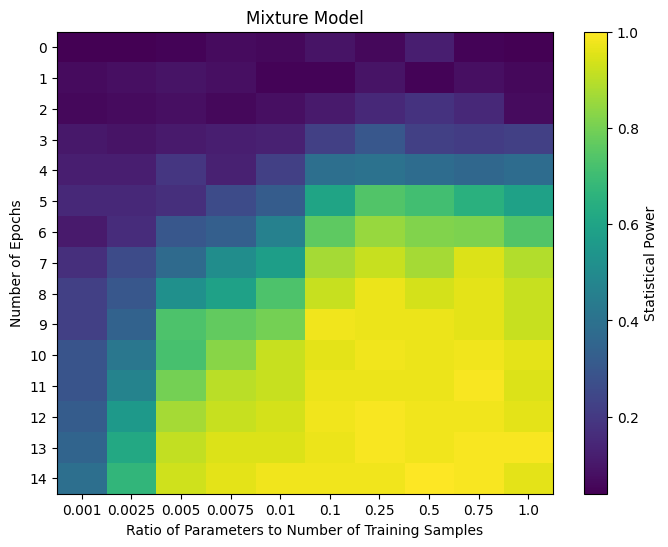

In [16]:
# linear output gaussian mixture model
try: df = pd.DataFrame(lin_power_dict_1)
except: df = pd.read_csv('lin_df_1.csv', index_col=[0]).dropna(axis=1)
plt.figure(figsize=(8, 6))
plt.imshow(df, cmap='viridis', aspect='auto')
cbar = plt.colorbar()  # Show colors
cbar.set_label('Statistical Power')
# Setting tick labels
_, _ = plt.xticks(range(len(df.columns)), df.columns)
_, _ = plt.yticks(range(len(df.index)), df.index)
plt.title('Mixture Model')
plt.xlabel('Ratio of Parameters to Number of Training Samples')
plt.ylabel('Number of Epochs')

Text(0, 0.5, 'Number of Epochs')

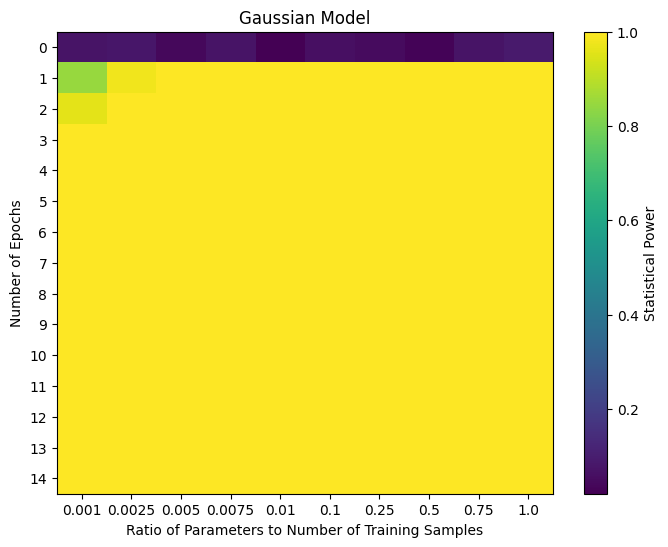

In [17]:
try: df = pd.DataFrame(lin_power_dict_2)
except: df = pd.read_csv('lin_df_2.csv', index_col=[0]).dropna(axis=1)
plt.figure(figsize=(8, 6))
plt.imshow(df, cmap='viridis', aspect='auto')
cbar = plt.colorbar()  # Show colors
cbar.set_label('Statistical Power')
# Setting tick labels
_, _ = plt.xticks(range(len(df.columns)), df.columns)
_, _ = plt.yticks(range(len(df.index)), df.index)
plt.title('Gaussian Model')
plt.xlabel('Ratio of Parameters to Number of Training Samples')
plt.ylabel('Number of Epochs')

# Plot logistic last layer statistical power as function of time and neural network complexity

In [ ]:
# linear output gaussian mixture model
df = pd.DataFrame(log_power_dict_1)
plt.figure(figsize=(8, 6))
plt.imshow(df, cmap='viridis', aspect='auto')
cbar = plt.colorbar()  # Show colors
cbar.set_label('Statistical Power | Logistic')
# Setting tick labels
_, _ = plt.xticks(range(len(df.columns)), df.columns)
_, _ = plt.yticks(range(len(df.index)), df.index)
plt.title('Mixture Model')
plt.xlabel('Ratio of Parameters to Number of Training Samples')
plt.ylabel('Number of Epochs')

In [ ]:
df = pd.DataFrame(log_power_dict_2)
plt.figure(figsize=(8, 6))
plt.imshow(df, cmap='viridis', aspect='auto')
cbar = plt.colorbar()  # Show colors
cbar.set_label('Statistical Power')
# Setting tick labels
_, _ = plt.xticks(range(len(df.columns)), df.columns)
_, _ = plt.yticks(range(len(df.index)), df.index)
plt.title('Gaussian Model | Logistic')
plt.xlabel('Ratio of Parameters to Number of Training Samples')
plt.ylabel('Number of Epochs')